In [1]:
import importlib
import theano.tensor as T
import sys, os
sys.path.append("/home/bl3/PycharmProjects/GeMpy/")
sys.path.append("/home/bl3/PycharmProjects/pygeomod/pygeomod")
import GeoMig
#import geogrid
#importlib.reload(GeoMig)
importlib.reload(GeoMig)
import numpy as np

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(precision = 15, linewidth= 300, suppress =  True)
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib qt4

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


In [3]:
test = GeoMig.GeoMigSim_pro2(c_o = np.float32(-0.1),range = 17)

test.create_regular_grid_3D(0,10,0,10,0,10,20,20,20)
test.theano_set_3D_nugget()

/home/miguel/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


In [4]:
layer_1 = np.array([[1,5,7], [9,5,6.8]], dtype = "float32")

layer_2 = np.array([[2,5,1],[7,5,2], [9,5,2]], dtype = "float32")

dip_pos_1 = np.array([2,5,6], dtype = "float32")
dip_pos_2 = np.array([6.,4,6], dtype = "float32")
dip_pos_3 = np.array([8,4,5], dtype = "float32")
dip_angle_1 = float(-45)
dip_angle_2 = float(45)


layers = np.asarray([layer_1,layer_2])
dips = np.asarray([dip_pos_1,dip_pos_2])#, dip_pos_3])
dips_angles = np.asarray([dip_angle_1, dip_angle_2], dtype="float32")
azimuths = np.asarray([2, 20], dtype="float32")
polarity = np.asarray([1, 1], dtype="float32")
#print (dips_angles)
rest = np.vstack((i[1:] for i in layers))
ref = np.vstack((np.tile(i[0],(np.shape(i)[0]-1,1)) for i in layers))
dips_angles.dtype
rest = rest.astype("float32")
ref = ref.astype("float32")
dips = dips.astype("float32")
dips_angles = dips_angles.astype("float32")
type(dips_angles)

numpy.ndarray

In [5]:
G_x = np.sin(np.deg2rad(dips_angles)) * np.sin(np.deg2rad(azimuths)) * polarity
G_y = np.sin(np.deg2rad(dips_angles)) * np.cos(np.deg2rad(azimuths)) * polarity
G_z = np.cos(np.deg2rad(dips_angles)) * polarity

G_x, G_y, G_z

(array([-0.024677669629455,  0.241844743490219], dtype=float32),
 array([-0.706676006317139,  0.664462983608246], dtype=float32),
 array([ 0.70710676908493,  0.70710676908493], dtype=float32))

In [6]:
test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0]

TypeError: Missing required input: <TensorType(float32, scalar)>

In [37]:
_,h1 = np.argmin((abs(test.grid - ref[0])).sum(1)), test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0][np.argmin((abs(test.grid - ref[0])).sum(1))]
_, h2 =np.argmin((abs(test.grid - ref[1])).sum(1)), test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0][np.argmin((abs(test.grid - ref[1])).sum(1))]

In [38]:
print(test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0][np.argmin((abs(test.grid - ref[0])).sum(1))])
for i in range(rest.shape[0]):
    print(test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0][np.argmin((abs(test.grid - rest[i])).sum(1))])

28.1950340271
28.237165451
25.3232555389
25.3343315125


In [39]:
test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0][np.argmin((abs(test.grid - rest[0])).sum(1))]

28.237165451049805

In [40]:
rest

array([[ 9. ,  5. ,  6.8],
       [ 7. ,  5. ,  2. ],
       [ 9. ,  5. ,  2. ]], dtype=float32)

In [41]:
sol = test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0].reshape(200,200,200, order = "C")[:,:,::-1].transpose()
#sol = np.swapaxes(sol,0,1)

In [42]:
G_x, G_y, G_z = test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[-3:]
G_x, G_y, G_z

(array([-0.02,  0.24], dtype=float32),
 array([-0.71,  0.66], dtype=float32),
 array([ 0.71,  0.71], dtype=float32))

In [43]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cmx

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
h =  np.array([h1,h2])
cm = plt.get_cmap("jet")
cNorm = matplotlib.colors.Normalize(vmin=h.min(), vmax=h.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)


sol = test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0].reshape(200,200,200,
    order = "C")[:,:,:]
#sol = np.swapaxes(sol,0,1)


from skimage import measure
isolines = np.linspace(h1,h2,2)
#vertices = measure.marching_cubes(sol, isolines[0], spacing = (0.2,0.2,0.2),
#    gradient_direction = "descent")[0]
for i in isolines[0:10]:
    vertices = measure.marching_cubes(sol, i, spacing = (0.05,0.05,0.05),
    gradient_direction = "ascent")[0]

    ax.scatter(vertices[::40,0],vertices[::40,1],vertices[::40,2],color=scalarMap.to_rgba(i),
     alpha = 0.2) #color=scalarMap.to_rgba(vertices[::10,2])
ax.scatter(layers[0][:,0],layers[0][:,1],layers[0][:,2], s = 50, c = "r" )
ax.scatter(layers[1][:,0],layers[1][:,1],layers[1][:,2], s = 50, c = "g" )
ax.quiver3D(dips[:,0],dips[:,1],dips[:,2], G_x,G_y,G_z, pivot = "tail", linewidths = 2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,10)
#ax.scatter(simplices[:,0],simplices[:,1],simplices[:,2])

(0, 10)

In [13]:
test.c_o.set_value(-0.56)
test.c_o.get_value()

array(-0.5600000023841858, dtype=float32)

In [7]:
test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,1,1,1,1,1,1)[1]

array([  0.               ,   0.               ,   0.               ,  -0.               ,  -0.               ,   0.               ,  -0.               ,   0.               ,   0.               ,   0.979540228843689,  10.698935508728027,  -0.213920593261719,   0.005893711932003,  -1.124314785003662,
         0.055647421628237,  -0.219372630119324,   0.011511720716953,   0.046046912670135], dtype=float32)

In [13]:
c_sol = np.array(([-7.2386541205560206435620784759521484375E-14],
            [-1.5265566588595902430824935436248779296875E-14],
            [-1.154631945610162802040576934814453125E-14],
            [6.21724893790087662637233734130859375E-15],
            
            [-5.9952043329758453182876110076904296875E-15],
            [7.99360577730112709105014801025390625E-15],
            
            [2.220446049250313080847263336181640625E-15],
            [-3.641531520770513452589511871337890625E-14],
            [8.0380146982861333526670932769775390625E-14],
            
            
            [0.8816416857576581111999303175252862274646759033203125],
            [9.355249580684368737593104015104472637176513671875],
            [-0.1793850547262900996248191631821100600063800811767578125],
        
            [0.047149729032205163481439313954979297704994678497314453125],
            [-8.994519501910499315044944523833692073822021484375],
           [ 0.4451793036427798000431721447966992855072021484375],
            
            [-1.7549816402777651536126768405665643513202667236328125],
            [0.0920938443689063301889063950511626899242401123046875],
            [0.36837537747562587586713789278292097151279449462890625])).squeeze()

In [71]:
c_sol.squeeze()

array([-0.000000000000072, -0.000000000000015, -0.000000000000012,  0.000000000000006, -0.000000000000006,  0.000000000000008,  0.000000000000002, -0.000000000000036,  0.00000000000008 ,  0.881641685757658,  9.355249580684369, -0.17938505472629 ,  0.047149729032205, -8.994519501910499,
        0.44517930364278 , -1.754981640277765,  0.092093844368906,  0.368375377475626])

In [8]:
import pymc as pm

In [108]:
a = pm.Uniform('a', lower=-1.1, upper=1.1, )
b = pm.Uniform('b', lower=-1.1, upper=1.1, )
c = pm.Uniform('c', lower=-1.1, upper=1.1, )
d = pm.Uniform('d', lower=-1.1, upper=1.1, )
e = pm.Uniform('e', lower=-1.1, upper=1.1, )
f = pm.Uniform('f', lower=-1.1, upper=1.1, )

@pm.deterministic
def this(value = 0, a = a ,b = b,c = c,d = d,e= e,f =f, c_sol = c_sol):
    sol = test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref,
                                 a,b,c,d,e,f)[1]

    
    #error = abs(sol-c_sol)
    #print (error)
    return sol
  
like= pm.Normal("likelihood", this, 1./np.square(0.00000000000001),
                value = c_sol, observed = True, size = len(c_sol)
)
model = pm.Model([a,b,c,d,e,f, like])    



In [109]:
M = pm.MAP(model)
M.fit()

In [113]:
N = pm.MCMC(model)
N.sample(10000, burn = 1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 189.2 sec

In [115]:
pm.Matplot.plot(N)

Plotting b
Plotting a
Plotting c
Plotting d
Plotting f
Plotting e


In [110]:
a.value, b.value

(array(-0.9430088797578566), array(-0.07238324557340177))

In [116]:
this.value

array([  0.               ,  -0.               ,   0.               ,  -0.               ,   0.000000000000001,  -0.000000000000001,   0.               ,  -0.               ,   0.               ,   0.979540228843689,  10.698935508728027,  -0.213920593261719,   0.005893711932003,  -1.124314785003662,
         0.055647421628237,  -0.219372630119324,   0.011511720716953,   0.046046912670135], dtype=float32)

In [112]:
c_sol

array([-0.000000000000072, -0.000000000000015, -0.000000000000012,  0.000000000000006, -0.000000000000006,  0.000000000000008,  0.000000000000002, -0.000000000000036,  0.00000000000008 ,  0.881641685757658,  9.355249580684369, -0.17938505472629 ,  0.047149729032205, -8.994519501910499,
        0.44517930364278 , -1.754981640277765,  0.092093844368906,  0.368375377475626])

In [1]:
import matplotlib.pyplot as plt

def plot_this_crap(direction):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    dip_pos_1_v = np.array([G_x[0], G_y[0],
                           G_z[0]]) + dip_pos_1

    dip_pos_2_v = np.array([G_x[1], G_y[1],
                           G_z[1]]) + dip_pos_2
    if direction == "x":

        plt.arrow(dip_pos_1[1],dip_pos_1[2], dip_pos_1_v[1]-dip_pos_1[1],
                  dip_pos_1_v[2]-dip_pos_1[2], head_width = 0.2)
        plt.arrow(dip_pos_2[1],dip_pos_2[2],dip_pos_2_v[1]-dip_pos_2[1], 
                  dip_pos_2_v[2]-dip_pos_2[2], head_width = 0.2)

        plt.plot(layer_1[:,1],layer_1[:,2], "o")
        plt.plot(layer_2[:,1],layer_2[:,2], "o")

        plt.plot(layer_1[:,1],layer_1[:,2], )
        plt.plot(layer_2[:,1],layer_2[:,2], )
        plt.contour( sol[25,:,:] ,30,extent = (0,10,0,10) )

    if direction == "y":

        plt.arrow(dip_pos_1[0],dip_pos_1[2], dip_pos_1_v[0]-dip_pos_1[0],
                  dip_pos_1_v[2]-dip_pos_1[2], head_width = 0.2)
        plt.arrow(dip_pos_2[0],dip_pos_2[2],dip_pos_2_v[0]-dip_pos_2[0], 
                  dip_pos_2_v[2]-dip_pos_2[2], head_width = 0.2)

        plt.plot(layer_1[:,0],layer_1[:,2], "o")
        plt.plot(layer_2[:,0],layer_2[:,2], "o")

        plt.plot(layer_1[:,0],layer_1[:,2], )
        plt.plot(layer_2[:,0],layer_2[:,2], )
        plt.contour( sol[:,25,:].T ,30,extent = (0,10,0,10) )

    if direction == "z":

        plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
                  dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
        plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
                  dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)

        plt.plot(layer_1[:,0],layer_1[:,1], "o")
        plt.plot(layer_2[:,0],layer_2[:,1], "o")

        plt.plot(layer_1[:,0],layer_1[:,1], )
        plt.plot(layer_2[:,0],layer_2[:,1], )
        plt.contour( sol[:,:,25] ,30,extent = (0,10,0,10) )
    
    
    
#plt.colorbar()
#plt.xlim(0,10)
#plt.ylim(0,10)
    plt.colorbar()
    plt.title("GeoBulleter v 0.1")

In [2]:
plot_this_crap("z")

NameError: name 'np' is not defined

In [50]:
h,j,k =sol[5,10,35], sol[25,5,5], sol[30,15,-25]
layer_1 = np.array([[1,5,7],[5,5,7],[6,5,7], [9,5,7]], dtype = "float32")

layer_2 = np.array([[1,5,1],[5,5,1],[9,5,1]], dtype = "float32")

print(sol[5,25,35], sol[25,25,35],  sol[30,25,35],  sol[45,25,35]) 
print(sol[5,25,5], sol[25,25,5],  sol[45,25,5])

6.05973 3.17981 2.4532 0.29113
6.14472 3.30846 0.500162


In [51]:
list(layer_1[0]*5)

[5.0, 25.0, 35.0]

In [52]:
interfaces_aux = test.geoMigueller(dips,dips_angles,azimuths,polarity,
                rest, ref)[0]


h = sol[10,20,30]# interfaces_aux[np.argmin(abs((test.grid - ref[0]).sum(1)))]
k = sol[30,15,25]# interfaces_aux[np.argmin(abs((test.grid - dips[0]).sum(1)))]
j = sol[45,25,5]#interfaces_aux[np.argmin(abs((test.grid - dips[-1]).sum(1)))]
h,k,j

(5.2851176, 2.330806, 0.50016159)

In [53]:
dips[-1], ref[0]

(array([ 6.,  3.,  5.], dtype=float32), array([ 1.,  5.,  7.], dtype=float32))

In [54]:
sol[30,15,25], sol[30,15,25]

(2.330806, 2.330806)

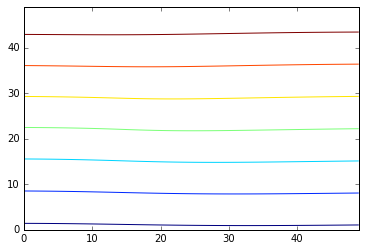

In [59]:
sol = test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0].reshape(50,50,50, order = "C")
sol = np.swapaxes(sol,0,1)
plt.contour(sol[:,25,:].transpose())

In [121]:
"""Export model to VTK

Export the geology blocks to VTK for visualisation of the entire 3-D model in an
external VTK viewer, e.g. Paraview.

..Note:: Requires pyevtk, available for free on: https://github.com/firedrakeproject/firedrake/tree/master/python/evtk

**Optional keywords**:
    - *vtk_filename* = string : filename of VTK file (default: output_name)
    - *data* = np.array : data array to export to VKT (default: entire block model)
"""
vtk_filename = "noddyFunct2"

extent_x = 10
extent_y = 10
extent_z = 10

delx = 0.2
dely = 0.2
delz = 0.2
from pyevtk.hl import gridToVTK
# Coordinates
x = np.arange(0, extent_x + 0.1*delx, delx, dtype='float64')
y = np.arange(0, extent_y + 0.1*dely, dely, dtype='float64')
z = np.arange(0, extent_z + 0.1*delz, delz, dtype='float64')

# self.block = np.swapaxes(self.block, 0, 2)


gridToVTK(vtk_filename, x, y, z, cellData = {"geology" : sol})

ImportError: No module named 'pyevtk'

In [201]:
len(x)

51

In [202]:
surf_eq.min()

-63.0

In [203]:
np.min(z)

0.0

In [204]:
layers[0][:,0]

array([ 1.,  5.,  6.,  9.], dtype=float32)

In [168]:
G_x = np.sin(np.deg2rad(dips_angles)) * np.sin(np.deg2rad(azimuths)) * polarity
G_y = np.sin(np.deg2rad(dips_angles)) * np.cos(np.deg2rad(azimuths)) * polarity
G_z = np.cos(np.deg2rad(dips_angles)) * polarity

In [183]:
a

array([[ 2.  ,  6.  ],
       [ 2.03,  6.15]], dtype=float32)

In [ ]:
data = [trace1, trace2]
layout = go.Layout(
    xaxis=dict(
        range=[2, 5]
    ),
    yaxis=dict(
        range=[2, 5]
    )
)
fig = go.Figure(data=data, layout=layout)

In [ ]:
import lxml
lxml??

In [11]:
# Random Box

#layers = [np.random.uniform(0,10,(10,2)) for i in range(100)]
#dips = np.random.uniform(0,10, (60,2))
#dips_angles = np.random.normal(90,10, 60)
#rest = (np.vstack((i[1:] for i in layers)))
#ref = np.vstack((np.tile(i[0],(np.shape(i)[0]-1,1)) for i in layers))
#rest;

[[-30.  -29.5 -29.  ...,  28.5  29.   29.5]
 [-30.  -29.5 -29.  ...,  28.5  29.   29.5]
 [-30.  -29.5 -29.  ...,  28.5  29.   29.5]
 ..., 
 [-30.  -29.5 -29.  ...,  28.5  29.   29.5]
 [-30.  -29.5 -29.  ...,  28.5  29.   29.5]
 [-30.  -29.5 -29.  ...,  28.5  29.   29.5]]


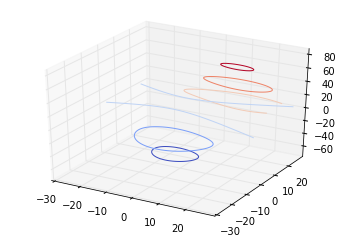

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
cset = ax.contour(X, Y, Z, cmap=cm.coolwarm)
ax.clabel(cset, fontsize=9, inline=1)
print(X)
plt.show()

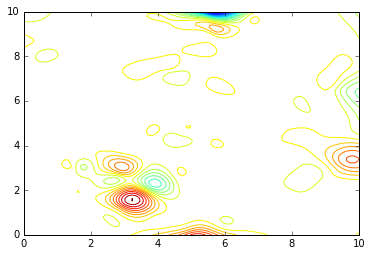

In [11]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.contour( sol.reshape(100,100) ,30,extent = (0,10,0,10) )

[ 2.  5.] [ 6.34  3.94] [[ 1.  7.]
 [ 5.  7.]
 [ 6.  7.]
 [ 9.  8.]]


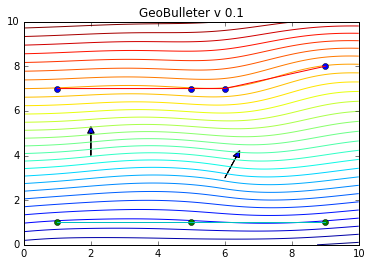

In [131]:
import matplotlib.pyplot as plt
% matplotlib inline
dip_pos_1_v = np.array([np.cos(np.deg2rad(dip_angle_1))*1,
                        np.sin(np.deg2rad(dip_angle_1))]) + dip_pos_1

dip_pos_2_v = np.array([np.cos(np.deg2rad(dip_angle_2))*1, 
                        np.sin(np.deg2rad(dip_angle_2))]) + dip_pos_2

plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
          dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
          dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)

plt.plot(layer_1[:,0],layer_1[:,1], "o")
plt.plot(layer_2[:,0],layer_2[:,1], "o")

plt.plot(layer_1[:,0],layer_1[:,1], )
plt.plot(layer_2[:,0],layer_2[:,1], )

plt.contour( sol.reshape(100,100) ,30,extent = (0,10,0,10) )
#plt.colorbar()
#plt.xlim(0,10)
#plt.ylim(0,10)
plt.title("GeoBulleter v 0.1")
print (dip_pos_1_v, dip_pos_2_v, layer_1)

# CPU

In [17]:
%%timeit
sol = test.geoMigueller(dips,dips_angles,rest, ref)[0]

1 loop, best of 3: 5.81 s per loop


In [18]:
test.geoMigueller.profile.summary()

Function profiling
  Message: /home/miguel/PycharmProjects/GeMpy/GeoMig.py:562
  Time in 5 calls to Function.__call__: 2.937774e+01s
  Time in Function.fn.__call__: 2.937736e+01s (99.999%)
  Time in thunks: 2.934835e+01s (99.900%)
  Total compile time: 1.559712e+00s
    Number of Apply nodes: 171
    Theano Optimizer time: 1.410723e+00s
       Theano validate time: 4.508591e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 9.198022e-02s
       Import time 0.000000e+00s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 132.105s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  83.6%    83.6%      24.529s       1.29e-01s     C      190      38   theano.tensor.elemwise.Elemwise
   6.4%    90.0%       1.889s       5.40e-02s     C       35       7   theano.tensor.elemwise.Sum
   5.1%    95.1%       1.496s       2.99e-02s     C       50      10   theano.tensor.blas.Dot22Scalar
   2.5%    97.6%       

In [23]:
sys.path.append("/home/bl3/anaconda3/lib/python3.5/site-packages/PyEVTK-1.0.0-py3.5.egg_FILES/pyevtk")
nx = 50
ny = 50
nz = 50

xmin = 1
ymin = 1
zmin = 1
grid =  sol
var_name = "Geology"
#from evtk.hl import gridToVTK
import pyevtk
from pyevtk.hl import gridToVTK

# define coordinates
x = np.zeros(nx + 1)
y = np.zeros(ny + 1)
z = np.zeros(nz + 1)
x[1:] = np.cumsum(delx)
y[1:] = np.cumsum(dely)
z[1:] = np.cumsum(delz)



# plot in coordinates
x += xmin
y += ymin
z += zmin

print (len(x), x)
gridToVTK("GeoMigueller", x, y, z,
          cellData = {var_name: grid})

51 [ 1.   1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2
  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2]


'/home/bl3/PycharmProjects/GeMpy/GeoMigueller.vtr'

## GPU

In [32]:
%%timeit
sol = test.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref);

10 loops, best of 3: 19.3 ms per loop


In [33]:
test.geoMigueller.profile.summary()

Function profiling
  Message: /home/miguel/PycharmProjects/GeMpy/GeoMig.py:1346
  Time in 48 calls to Function.__call__: 1.300695e+00s
  Time in Function.fn.__call__: 1.296489e+00s (99.677%)
  Time in thunks: 1.084233e+00s (83.358%)
  Total compile time: 2.702078e+00s
    Number of Apply nodes: 295
    Theano Optimizer time: 2.239654e+00s
       Theano validate time: 1.687617e-01s
    Theano Linker time (includes C, CUDA code generation/compiling): 3.944879e-01s
       Import time 6.902671e-02s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 533.471s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  37.5%    37.5%       0.407s       3.14e-04s     C     1296      27   theano.tensor.elemwise.Elemwise
  26.3%    63.8%       0.285s       5.93e-04s     C      480      10   theano.tensor.blas.Dot22Scalar
   9.7%    73.5%       0.105s       9.96e-05s     C     1056      22   theano.sandbox.cuda.basic_ops.GpuFromHost
   9.0

In [30]:
importlib.reload(GeoMig)
test = GeoMig.GeoMigSim_pro2()

array([[ -5.88888884e-01,  -0.00000000e+00,  -0.00000000e+00, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [ -0.00000000e+00,  -5.88888884e-01,   4.42373231e-02, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [ -0.00000000e+00,   2.12696299e-01,  -5.88888884e-01, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.00000000e+00,  -6.06459351e+02,  -6.13501053e+01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
         -6.06459351e+02,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -6.13501053e+01,   0.00000000e+00,   0.00000000e+00]], dtype=float32)

Exception: Can't change the value of this config parameter after initialization!

In [1]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]
Looping 1000 times took 2.271379 seconds
Result is [ 1.23178029  1.61879337  1.52278066 ...,  2.20771813  2.29967761
  1.62323284]
Used the cpu


In [1]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.353415 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [18]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]
Looping 1000 times took 2.291412 seconds
Result is [ 1.23178029  1.61879337  1.52278066 ...,  2.20771813  2.29967761
  1.62323284]
Used the cpu


In [759]:
np.set_printoptions(precision=2)
test.geoMigueller(dips,dips_angles,rest, ref)[1]

array([[-0.59,  0.08,  0.  ,  0.07],
       [ 0.08, -0.59,  0.07,  0.  ],
       [ 0.  ,  0.12, -0.59,  0.13],
       [ 0.07,  0.  ,  0.13, -0.59]])

In [751]:
T.fill_diagonal?

[ 2.5   4.87] [ 6.34  3.94] [[ 1.  7.]
 [ 5.  7.]
 [ 6.  7.]
 [ 9.  8.]]


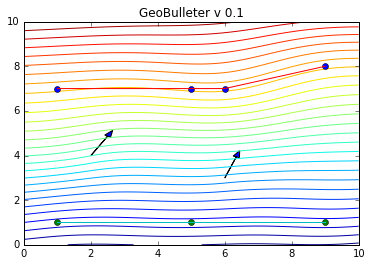

In [758]:
import matplotlib.pyplot as plt
% matplotlib inline
dip_pos_1_v = np.array([np.cos(np.deg2rad(dip_angle_1))*1,
                        np.sin(np.deg2rad(dip_angle_1))]) + dip_pos_1

dip_pos_2_v = np.array([np.cos(np.deg2rad(dip_angle_2))*1, 
                        np.sin(np.deg2rad(dip_angle_2))]) + dip_pos_2

plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
          dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
          dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)

plt.plot(layer_1[:,0],layer_1[:,1], "o")
plt.plot(layer_2[:,0],layer_2[:,1], "o")

plt.plot(layer_1[:,0],layer_1[:,1], )
plt.plot(layer_2[:,0],layer_2[:,1], )

plt.contour( sol.reshape(50,50) ,30,extent = (0,10,0,10) )
#plt.colorbar()
#plt.xlim(0,10)
#plt.ylim(0,10)
plt.title("GeoBulleter v 0.1")
print (dip_pos_1_v, dip_pos_2_v, layer_1)

In [443]:
n = 10
#a = T.horizontal_stack(T.vertical_stack(T.ones(n),T.zeros(n)), T.vertical_stack(T.zeros(n), T.ones(n)))
a = T.zeros(n)

print (a.eval())
#U_G = T.horizontal_stack(([T.ones(n),T.zeros(n)],[T.zeros(n),T.ones(n)]))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [6]:
T.stack?ö+aeg

In [13]:
x_min = 0
x_max = 10
y_min = 0
y_max = 10
z_min = 0
z_max = 10
nx = 2
ny = 2
nz = 2

g = np.meshgrid(
    np.linspace(x_min, x_max, nx, dtype="float32"),
    np.linspace(y_min, y_max, ny, dtype="float32"),
    np.linspace(z_min, z_max, nz, dtype="float32"), indexing="ij"
)

np.vstack(map(np.ravel, g)).T.astype("float32")

array([[  0.,   0.,   0.],
       [  0.,   0.,  10.],
       [  0.,  10.,   0.],
       [  0.,  10.,  10.],
       [ 10.,   0.,   0.],
       [ 10.,   0.,  10.],
       [ 10.,  10.,   0.],
       [ 10.,  10.,  10.]], dtype=float32)

In [18]:
map(np.ravel, g)

In [22]:
np.ravel(g, order = "F")

array([  0.,   0.,   0.,  10.,   0.,   0.,   0.,  10.,   0.,  10.,  10.,   0.,   0.,   0.,  10.,  10.,   0.,  10.,   0.,  10.,
        10.,  10.,  10.,  10.])

In [23]:
g

[array([[[  0.,   0.],
         [  0.,   0.]],
 
        [[ 10.,  10.],
         [ 10.,  10.]]]), array([[[  0.,   0.],
         [ 10.,  10.]],
 
        [[  0.,   0.],
         [ 10.,  10.]]]), array([[[  0.,  10.],
         [  0.,  10.]],
 
        [[  0.,  10.],
         [  0.,  10.]]])]

In [25]:
np.transpose?